## Applied chemical process engineering - Python

#### Import of Packages

In [1]:
!pip install scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint as odeint
from scipy.optimize import fmin
import math
from IPython.display import display, Math, Latex


  Using cached scipy-1.7.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.8 MB)


#### Experimental Values:

    c0    := Starting Values of concentrations in mol/L 
    t_exp := Time measured in the experiment

In [2]:
c0 = [[14e-3 * i, 2.25e-3, 0, 1.67e-3] for i in [1, 1.5, 2, 3]]
t_exp = [33, 21, 15, 10]

$$\require{mhchem}$$
#### Chemical Reactions

- $\ce{Fe^3+ + S2O3^2- <=> [Fe(S2O3)]^+}$

- $\ce{2Fe^3+ + 3I^- -> 2Fe^2+ + I3^-}$

- $\ce{I3^- + 2S2O3^2+ -> 3I^- + S4O6^2-} $

- $\ce{2I3^- + starch -> starch{-}I5^- + I-} $

Note: Not all reactions are relevant here! The first reaction is reversible and very fast, therefor it can be neglected. The last reaction is the formation of the blue complex. This happens instantaneously when $\ce{I3^-} $ is present in the solution. The complex-forming reaction can be negelected, when $\ce{I3^-} $ is used as indicator for the color formation. 

#### Indices:  


c0[0] = $\ce{Fe^3+}$  
c0[1] = $\ce{I^-}$    
c0[2] = $\ce{I3^-}$    
c0[3] = $\ce{S2O3^2+}$  

#### Reaction Rates: 

Define a function that calculates the reaction rates. The reaction of Iron and Iodine is first and second order with respect to iron(III) ions and Iodine ions, respectively. Assume all remaining reactions to be elementary. 

$ R_i = k_i(T) \prod_{j} c_{j}^{n_{ij}} $

Calculate each component's concentration gradient for a given reaction rate. Take into acocunt that there are multiple reactions. 

$ \frac{dc_i}{dt} = \sum_{j} \nu_{i,j} R_j $

In [3]:
def reaction_rates(c, t, k):
    r = [
        k[0] * c[0] * c[1]**2, 
        k[1] * c[2] * c[3]**2
    ]
    dc = [
        -2 * r[0], 
        -3 * r[0] + 3 * r[1], 
        r[0] - r[1], 
        -2 * r[1]
    ]
    return(dc)


#### Simulated Batch Experiment:

Simulate a batch experiment using the Explicit-Euler approach to solve the differential equation. 

$c_{i+1} = c_{i} + \frac{dc_i}{dt} \Delta t $


<img src="Explicit-Euler.png" alt="explicit-Euler" style="width: 800px;"/>




In [4]:
def batch_experiment(c, k, t_max, t_step):
    steps = int(t_max / t_step)
    cs = np.zeros((steps+1, len(c)))
    cs[0] = np.float64(c)
    for i in range(steps):
        for j in range(len(c)):
            cs[i+1][j] = cs[i][j] + reaction_rates(cs[i], 1, k)[j] * t_step
            if cs[i+1][j] < 0:
                cs[i+1][j] = 0
    return(cs)


**Parameters for the Simulation**

You need some parameters to simulate the batch experiment. Try out different values. You might want to plot the concentrations of your simulated experiment. 

    k     := Vector of reaction constants (starting values: [300, 6e8])
    t_max := Maximum time of the simulated reaction
    t_step:= Time Step used for the simulation

In [5]:
k = [300, 6e8]
t_max = 80
steps = 50000
t_step = 80 / steps
c_lim = 2e-05


This function uses [odeint]('https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html') to solve the differential equation. This is much faster than the self-implemented explicit euler, saving a lot of computational time during the fitting. 

In [6]:
def ode_experiment(cs, k, t_max, t_step):
    steps = int(t_max/t_step)
    t = np.linspace(0, t_max, steps)
    c = odeint(reaction_rates, cs, t, args=((k,)))
    return(c)


Write a funtion to plot the concentration profiles. Compare the results of the self-implemented explicit euler and the odeint function. Investigate the influence of the step-size on the simulation results. 

In [7]:
def plot(c):
    t = np.linspace(0, t_max, len(c))
    plt.figure(figsize=(4, 3))
    plt.plot(t, c[:])
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration (M)')
    plt.legend(['Fe3+', 'I-', 'I3-', 'S2O32+'])

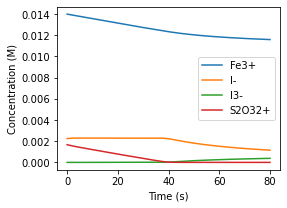

In [8]:
plot(batch_experiment(c0[0], k, t_max, t_step))

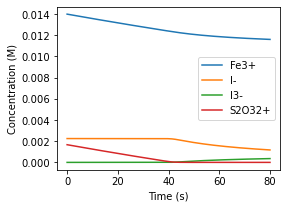

In [9]:
plot(ode_experiment(c0[0], k, t_max, t_step))

#### Simulated Time:

Determine the time of the color change. The necessary concentration for the color change is not known, assume $c_{I3, lim} = 2e-5$. 


In [10]:
def simulate_time(c, k, t_max, t_step):
    cs = ode_experiment(c, k, t_max, t_step)
    for i, c in enumerate(cs):
        if c[2] > c_lim:
            break
    sim_time = t_step * i
    return(sim_time)

#### Error Function:

Define the error function. 

The error function sums up the squares of the difference between the simulated and experimental time for all experiments.

In [11]:
def error_func(k, c0, times):
    sim_times = []
    for c in c0: 
        sim_times.append(simulate_time(c, k, t_max, t_step))
    deltas = [np.sqrt((sim_time - time)**2) for sim_time, time in zip(sim_times, times)]
    # print('Error: {}'.format(sum(i**2 for i in deltas)))
    return(sum(i**2 for i in deltas))
    

##### Optimize:

Use the function [scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html) to fit the reation constants k to minimize the time difference between experiment and simulation. 

In [12]:
kr = fmin(error_func, k, args=(c0, t_exp), xtol=0.0001, ftol=0.0001, disp=1)
print(kr)

Optimization terminated successfully.
         Current function value: 0.146266
         Iterations: 92
         Function evaluations: 243
[3.61126846e+02 4.41495203e+07]


#### Plotting:

Plot the simulated concentrations. Mark the simulated and experimentally measured time of the color change.

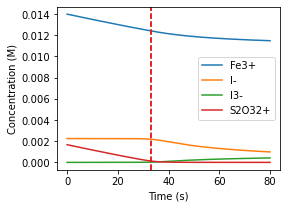

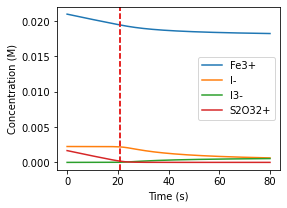

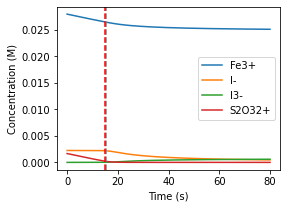

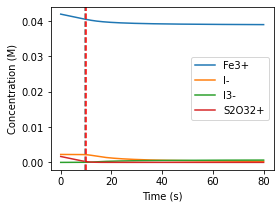

In [13]:
for c0i, time in zip(c0, t_exp):
    c = batch_experiment(c0i, kr, t_max, t_step)
    t = np.linspace(0, t_max, steps)
    plt.figure(figsize=(4, 3))
    plt.plot(t, c[1:])
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration (M)')
    plt.legend(['Fe3+', 'I-', 'I3-', 'S2O32+'])
    plt.axvline(x=simulate_time(c0i, kr, t_max, t_step), color='gray', linestyle='--')
    if time:
        plt.axvline(x=time, color='r', linestyle='--')